APAGAR DEPOIS


Requisitos:
- Identificar a localização desenhando um Bounding-Box ao redor da moeda
- Informar o valor da moeda
- Apresentar o desempenho do algoritmo
- Matriz de Confusão e Percentual
- Análise de erros
- Deve-se utilizar um algoritmo de machine learning (KNN, SVM)
- Não é permitido o uso de Deep Learning


comentar funções



# TDE01 - DIGITAR INFO




FALAR SOBRE IMPORTS




In [139]:
%matplotlib inline

import os, cv2, random, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from google.colab.patches import cv2_imshow # for image display

from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import threshold_otsu, threshold_local
from skimage.feature import local_binary_pattern

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

!wget https://www.inf.ufpr.br/aghochuli/dataset3.zip -O dataset3.zip
!unzip dataset3.zip


imgs = []

for img_path in os.listdir('./dataset3/'):
    imgs.append([io.imread('./dataset3/' + img_path),img_path])
    
print(len(imgs),"images loaded")

--2021-08-31 00:19:32--  https://www.inf.ufpr.br/aghochuli/dataset3.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35758483 (34M) [application/zip]
Saving to: ‘dataset3.zip’

dataset3.zip        100%[===================>]  34.10M  14.3MB/s    in 2.4s    

2021-08-31 00:19:35 (14.3 MB/s) - ‘dataset3.zip’ saved [35758483/35758483]

Archive:  dataset3.zip
replace dataset3/5_1477189488.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset3/5_1477189488.jpg  
  inflating: dataset3/100_1477280538.jpg  
  inflating: dataset3/50_1477282872.jpg  
  inflating: dataset3/10_1477147452.jpg  
  inflating: dataset3/50_1477283088.jpg  
  inflating: dataset3/10_1477288506.jpg  
  inflating: dataset3/10_1477288476.jpg  
  inflating: dataset3/100_1477281726.jpg  
  inflating: dataset3/5_1477290534.jpg  


### AJUSTE DO DATASET

Falar sobre ajustes e fazer mais ajustes

In [140]:
for i in range(len(imgs)):

    imgs[i][0] = resize(imgs[i][0], (64, 80), anti_aliasing=True)

    imgs[i][0] = np.array(rgb2hsv(imgs[i][0]))[:, :, 1]

    thresh_min = threshold_otsu(imgs[i][0])
    binary_min = imgs[i][0] > thresh_min
    

    ## REVER
    imgs[i][0] = np.array([ [1.0 if v else 0.0 for v in _] for _ in binary_min]) # rever dimensions problema lbp


"""
ValueError                                Traceback (most recent call last)
<ipython-input-143-deabd6d83c9b> in <module>()
     30             data_refs_lbp[i].append(local_binary_pattern(j, n_points, radius, METHOD))
     31 
---> 32 setdata(training, training_refs, training_refs_lbp)
     33 setdata(validation, validation_refs, validation_refs_lbp)
     34 setdata(testing, testing_refs, testing_refs_lbp)

2 frames
/usr/local/lib/python3.7/dist-packages/skimage/_shared/utils.py in check_nD(array, ndim, arg_name)
    181         raise ValueError(msg_empty_array % (arg_name))
    182     if not array.ndim in ndim:
--> 183         raise ValueError(msg_incorrect_dim % (arg_name, '-or-'.join([str(n) for n in ndim])))
    184 
    185 

ValueError: The parameter `image` must be a 2-dimensional array

"""

## COIN DETECTION

Identificar a localização desenhando um Bounding-Box ao redor da moeda


## SPLIT DO DATASET

In [141]:
def frequenceDict(data):

    arr = {}
    for i in data:
        arr[(i[1].split("_")[0])] = 0

    for i in data:
        arr[i[1].split("_")[0]] += 1

    return arr


def mapdistribution(partitions, freq_dict):

    ret = []

    for p in partitions:
        ret_ = {}
        for f in freq_dict.keys():
            ret_[f] = freq_dict[f] * p 
        ret.append(ret_)

    return ret


def load_balance_split(data, mapdistribution_):
    
    ret = [ [] for _ in mapdistribution_]

    for d in data:

        for match in range(len(mapdistribution_)):

            if mapdistribution_[match][d[1].split("_")[0]] > 0:

                ret[match].append(d)

                mapdistribution_[match][d[1].split("_")[0]] -= 1

                break

    return (*ret,)

In [142]:
freqdict = frequenceDict(imgs)
mapd = mapdistribution([0.5, 0.2, 0.3], freqdict)

training, validation, testing = load_balance_split(imgs, mapd)

In [143]:

METHOD = 'uniform' #non-uniform || flat
radius = 3
n_points = 8 * radius

training_refs, training_refs_lbp = {}, {}
validation_refs, validation_refs_lbp = {}, {}
testing_refs, testing_refs_lbp = {}, {}


coin_labels = []
[coin_labels.append(i[1].split("_")[0]) for i in training]


for i in list(set(coin_labels)):
    training_refs[i], training_refs_lbp[i] = [], []
    validation_refs[i], validation_refs_lbp[i] = [], []
    testing_refs[i], testing_refs_lbp[i] = [], []

def setdata(data, data_refs, data_refs_lbp):
    
    for i in data:

        data_refs [ i[1].split("_")[0] ] = i[0]
    
    for i in data_refs.keys():
        
        for j in data_refs[i]:

            data_refs_lbp[i].append(local_binary_pattern(j, n_points, radius, METHOD))

setdata(training, training_refs, training_refs_lbp)
setdata(validation, validation_refs, validation_refs_lbp)
setdata(testing, testing_refs, testing_refs_lbp)

def setlist(data_refs, data_refs_lbp):

    data_refs_arr = []
    data_refs_lbp_arr = []

    for i in data_refs.keys():

        [ data_refs_arr.append(j) for j in data_refs[i]]

        [ data_refs_lbp_arr.append(i) for _ in range(len(data_refs[i]))]

    datanp = np.array(data_refs_arr)

    datanp = datanp.reshape(datanp.shape[0], -1)

    return datanp, np.array(data_refs_lbp_arr)


training_refs_lbp, training_refs_value = setlist(training_refs, training_refs_lbp)
validation_refs_lbp, validation_refs_value = setlist(validation_refs, validation_refs_lbp)
testing_refs_lbp, testing_refs_value = setlist(testing_refs, testing_refs_lbp)



ValueError: ignored

## MODELOS

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(training_refs_lbp, training_refs_value)


preds = KNN.predict(testing_refs_lbp)

sns.heatmap(confusion_matrix(testing_refs_value, preds), annot=True)

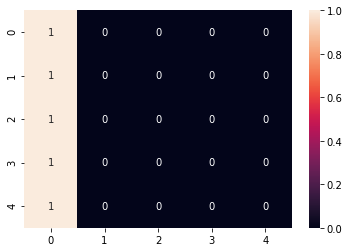

In [136]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

#testar scalers ~ robust scaler.

clf.fit(training_refs_lbp, training_refs_value)

preds = clf.predict(testing_refs_lbp)

sns.heatmap(confusion_matrix(testing_refs_value, preds), annot=True)

In [137]:


logReg = LogisticRegression(random_state=9, solver='newton-cg', max_iter=1000, multi_class='ovr')
## solver {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

logReg.fit(training_refs_lbp, training_refs_value)

preds = logReg.predict(testing_refs_lbp)


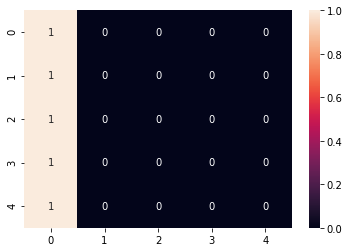

In [138]:
sns.heatmap(confusion_matrix(testing_refs_value, preds), annot=True)

In [56]:
## TESTAR

ada = AdaBoostClassifier(n_estimators=100, random_state=0,algorithm='SAMME',learning_rate=0.12)
rf = RandomForestClassifier(n_estimators=800, random_state=10)
dt     =  DecisionTreeClassifier(criterion='entropy')